# Chapter 13: Batchin' Up

Paolo Perrotta, Programming Machine Learning: From Coding to Deep Learning (2020)

## Learning, Visualized

In [1]:
# Load MNIST

import numpy as np
import gzip
import struct


def load_images(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Read the header information into a bunch of variables:
        _ignored, n_images, columns, rows = struct.unpack('>IIII', f.read(16))
        # Read all the pixels into a NumPy array:
        all_pixels = np.frombuffer(f.read(), dtype=np.uint8)
        # Reshape the pixels into a matrix where each line is an image:
        return all_pixels.reshape(n_images, columns * rows)


# 60000 images, each 784 elements (28 * 28 pixels)
X_train = load_images("../data/mnist/train-images-idx3-ubyte.gz") #注意檔案路徑是否正確

# 10000 images, each 784 elements, with the same structure as X_train
X_test = load_images("../data/mnist/t10k-images-idx3-ubyte.gz") #注意檔案路徑是否正確


def load_labels(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Skip the header bytes:
        f.read(8)
        # Read all the labels into a list:
        all_labels = f.read()
        # Reshape the list of labels into a one-column matrix:
        return np.frombuffer(all_labels, dtype=np.uint8).reshape(-1, 1)


def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = 10
    encoded_Y = np.zeros((n_labels, n_classes))
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y


# 60K labels, each a single digit from 0 to 9
Y_train_unencoded = load_labels("../data/mnist/train-labels-idx1-ubyte.gz") #注意檔案路徑是否正確

# 60K labels, each consisting of 10 one-hot encoded elements
Y_train = one_hot_encode(Y_train_unencoded)

# 10000 labels, each a single digit from 0 to 9
Y_test = load_labels("../data/mnist/t10k-labels-idx1-ubyte.gz") #注意檔案路徑是否正確

In [2]:
print(Y_train_unencoded[0:3])
print(Y_train[0:3])

[[5]
 [0]
 [4]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# Show matplot charts inside this Jupyter Notebook
%matplotlib inline

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(logits):
    exponentials = np.exp(logits)
    return exponentials / np.sum(exponentials, axis=1).reshape(-1, 1)

def sigmoid_gradient(sigmoid):
    return np.multiply(sigmoid, (1 - sigmoid))

def loss(Y, y_hat):
    return -np.sum(Y * np.log(y_hat)) / Y.shape[0]

def prepend_bias(X):
    return np.insert(X, 0, 1, axis=1)

def forward(X, w1, w2):
    h = sigmoid(np.matmul(prepend_bias(X), w1))
    y_hat = softmax(np.matmul(prepend_bias(h), w2))
    return (y_hat, h)

def back(X, Y, y_hat, w2, h):
    w2_gradient = np.matmul(prepend_bias(h).T, (y_hat - Y)) / X.shape[0]
    w1_gradient = np.matmul(prepend_bias(X).T, np.matmul(y_hat - Y, w2[1:].T)
                            * sigmoid_gradient(h)) / X.shape[0]
    return (w1_gradient, w2_gradient)

def classify(X, w1, w2):
    y_hat, _ = forward(X, w1, w2)
    labels = np.argmax(y_hat, axis=1)
    return labels.reshape(-1, 1)

def initialize_weights(n_input_variables, n_hidden_nodes, n_classes):
    w1_rows = n_input_variables + 1
    w1 = np.random.randn(w1_rows, n_hidden_nodes) * np.sqrt(1 / w1_rows)

    w2_rows = n_hidden_nodes + 1
    w2 = np.random.randn(w2_rows, n_classes) * np.sqrt(1 / w2_rows)

    return (w1, w2)


def report(iteration, X_train, Y_train, X_test, Y_test, w1, w2):
    y_hat, _ = forward(X_train, w1, w2)
    training_loss = loss(Y_train, y_hat)
    classifications = classify(X_test, w1, w2)
    accuracy = np.average(classifications == Y_test) * 100.0
    print("Iteration: %5d, Loss: %.8f, Accuracy: %.2f%%" %
          (iteration, training_loss, accuracy))
    return (training_loss, accuracy)


def train(X_train, Y_train, X_test, Y_test, n_hidden_nodes, iterations, lr):
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]

    loss_history = []
    accuracy_history = []
    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    for i in range(iterations):
        y_hat, h = forward(X_train, w1, w2)
        training_loss = loss(Y_train, y_hat)
        w1_gradient, w2_gradient = back(X_train, Y_train, y_hat, w2, h)
        w1 = w1 - (w1_gradient * lr)
        w2 = w2 - (w2_gradient * lr)
        training_loss, accuracy = report(i, X_train, Y_train, X_test, Y_test,
                                         w1, w2)
        loss_history.append(training_loss)
        accuracy_history.append(accuracy)
    return (loss_history, accuracy_history)

In [5]:
# Optional: seed the random generator
np.random.seed(1234)

Iteration:     0, Loss: 2.38746031, Accuracy: 13.61%
Iteration:     1, Loss: 2.34527197, Accuracy: 15.00%
Iteration:     2, Loss: 2.30606144, Accuracy: 16.20%
Iteration:     3, Loss: 2.26964373, Accuracy: 17.95%
Iteration:     4, Loss: 2.23536024, Accuracy: 19.33%
Iteration:     5, Loss: 2.20259660, Accuracy: 21.03%
Iteration:     6, Loss: 2.17130247, Accuracy: 22.63%
Iteration:     7, Loss: 2.14179651, Accuracy: 24.54%
Iteration:     8, Loss: 2.11374257, Accuracy: 26.22%
Iteration:     9, Loss: 2.08687697, Accuracy: 28.08%
Iteration:    10, Loss: 2.06088792, Accuracy: 29.89%
Iteration:    11, Loss: 2.03576266, Accuracy: 31.93%
Iteration:    12, Loss: 2.01170585, Accuracy: 33.70%
Iteration:    13, Loss: 1.98840241, Accuracy: 35.65%
Iteration:    14, Loss: 1.96597698, Accuracy: 37.37%
Iteration:    15, Loss: 1.94438512, Accuracy: 39.23%
Iteration:    16, Loss: 1.92347162, Accuracy: 41.06%
Iteration:    17, Loss: 1.90303485, Accuracy: 42.58%
Iteration:    18, Loss: 1.88294585, Accuracy: 

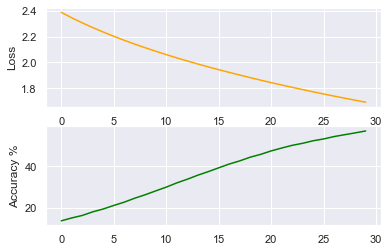

In [6]:
# Plot loss across ITERATIONS training iterations
ITERATIONS = 30

loss_history, accuracy_history = train(X_train, Y_train,X_test, Y_test,
                                       n_hidden_nodes=200,iterations=ITERATIONS,lr=0.01)

plt.subplot(2, 1, 1)
plt.ylabel("Loss")
plt.plot(loss_history, color='orange')

plt.subplot(2, 1, 2)
plt.ylabel("Accuracy %")
plt.plot(accuracy_history, color='green')

plt.show()

## Batch by Batch

In [7]:
def prepare_batches(X_train, Y_train, batch_size):
    x_batches = []
    y_batches = []
    n_examples = X_train.shape[0]
    for batch in range(0, n_examples, batch_size):
        batch_end = batch + batch_size
        x_batches.append(X_train[batch:batch_end])
        y_batches.append(Y_train[batch:batch_end])
    return x_batches, y_batches

In [28]:
tmpx = np.array([[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]])
tmpy = np.array([[0], [1], [0], [1], [0], [1], [0], [1], [0], [1]])
print(tmpx)
tmpx_batches, tmpy_batches = prepare_batches(tmpx, tmpy, 2)
print(len(tmpx_batches))
tmpx_batches


[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
5


[array([[0],
        [1]]),
 array([[2],
        [3]]),
 array([[4],
        [5]]),
 array([[6],
        [7]]),
 array([[8],
        [9]])]

In [8]:
def report(epoch, batch, X_train, Y_train, X_test, Y_test, w1, w2):
    y_hat, _ = forward(X_train, w1, w2)
    training_loss = loss(Y_train, y_hat)
    classifications = classify(X_test, w1, w2)
    accuracy = np.average(classifications == Y_test) * 100.0
    print("%5d-%d > Loss: %.8f, Accuracy: %.2f%%" %
          (epoch, batch, training_loss, accuracy))


def train(X_train, Y_train, X_test, Y_test, n_hidden_nodes,epochs, batch_size, lr):
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]

    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    x_batches, y_batches = prepare_batches(X_train, Y_train, batch_size)
    for epoch in range(epochs):
        for batch in range(len(x_batches)):
            y_hat, h = forward(x_batches[batch], w1, w2)
            w1_gradient, w2_gradient = back(x_batches[batch], y_batches[batch],
                                            y_hat, w2, h)
            w1 = w1 - (w1_gradient * lr)
            w2 = w2 - (w2_gradient * lr)
            report(epoch, batch, X_train, Y_train, X_test, Y_test, w1, w2)
    return (w1, w2)

In [9]:
w1, w2 = train(X_train, Y_train, X_test, Y_test,
               n_hidden_nodes=200, epochs=2, batch_size=20000, lr=0.01)

    0-0 > Loss: 2.34087964, Accuracy: 11.34%
    0-1 > Loss: 2.30285210, Accuracy: 13.07%
    0-2 > Loss: 2.26698586, Accuracy: 14.82%
    1-0 > Loss: 2.23393354, Accuracy: 16.98%
    1-1 > Loss: 2.20321348, Accuracy: 19.33%
    1-2 > Loss: 2.17326650, Accuracy: 21.54%


## Understanding Batches

In [10]:
import time

# This train() is different from the original one in a few ways:
# * it goes on until a specified time has passed, rather than after a specified
#   number of epochs;
# * it does its job quietly instead of reporting the loss and accuracy at each
#   step;
# * it stores the loss and the time passed after each step, so that it can
#   return that history to the caller;
# * it also returns the number of training epochs and the total number of
#   gradient descent steps.
def train(X_train, Y_train, X_test, Y_test,
          n_hidden_nodes, lr, batch_size, time_in_seconds):
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]

    w1, w2 = initialize_weights(n_input_variables,
                                   n_hidden_nodes, n_classes)
    x_batches, y_batches = prepare_batches(X_train, Y_train, batch_size)

    start_time = time.time()
    times = []
    losses = []
    epochs = 0
    steps = 0
    while True:
        batch = 0
        while (batch < len(x_batches)):
            training_classifications, _ = forward(X_train, w1, w2)
            training_loss = loss(Y_train, training_classifications)
            times.append(np.floor(time.time() - start_time))
            losses.append(training_loss)

            time_passed = time.time() - start_time
            if time_passed > time_in_seconds:
                return (times, losses, epochs, steps)

            y_hat, h = forward(x_batches[batch], w1, w2)
            w1_gradient, w2_gradient = back(x_batches[batch],
                                        y_batches[batch],
                                               y_hat, w2, h)
            w1 = w1 - (w1_gradient * lr)
            w2 = w2 - (w2_gradient * lr)

            batch += 1
            steps += 1
        epochs += 1

In [11]:
def plot_loss(n_hidden_nodes, batch_size, lr,
              time_in_seconds, label, color):
    print("Training:", label)
    times, losses, epochs, steps = train(X_train, Y_train,
                                         X_test, Y_test,
                                         n_hidden_nodes=n_hidden_nodes,
                                         batch_size=batch_size, lr=lr,
                                         time_in_seconds=time_in_seconds)
    print("  Loss: %.8f (%d epochs completed, %d total steps)" %
          (losses[-1], epochs, steps))
    plt.plot(times, losses, label=label, color=color)


def show_plot():
    sns.set()

    plt.xlabel("Seconds")
    plt.ylabel("Loss")

    # Add a legend and show the chart
    plt.legend()
    plt.show()

Training: Stochastic GD


<ipython-input-4-a743002ee2c1>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


  Loss: 2.20396047 (0 epochs completed, 127 total steps)
Training: Batch size 32
  Loss: 1.11836554 (0 epochs completed, 137 total steps)
Training: Batch size 128
  Loss: 0.93427890 (0 epochs completed, 138 total steps)
Training: Batch GD
  Loss: 1.54443043 (46 epochs completed, 46 total steps)


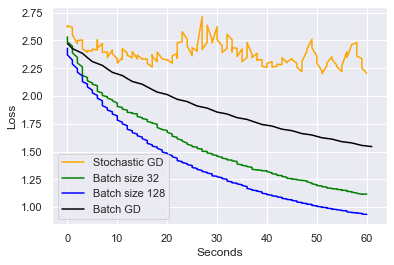

In [12]:
# -------------------------------------------------------
# Change the following lines to make your own comparisons

# The running time of each batch size, in seconds
# (for the diagrams in the book, I used 1800 seconds):
TIME = 60

# The number of hidden nodes:
HIDDEN_NODES = 200

# The learning rate:
lr = 0.01

plot_loss(n_hidden_nodes=HIDDEN_NODES,
          batch_size=1, lr=lr,
          time_in_seconds=TIME,
          label="Stochastic GD", color='orange')
plot_loss(n_hidden_nodes=HIDDEN_NODES,
          batch_size=32, lr=lr,
          time_in_seconds=TIME,
          label="Batch size 32", color='green')
plot_loss(n_hidden_nodes=HIDDEN_NODES,
          batch_size=128, lr=lr,
          time_in_seconds=TIME,
          label="Batch size 128", color='blue')
plot_loss(n_hidden_nodes=HIDDEN_NODES,
          batch_size=X_train.shape[0], lr=lr,
          time_in_seconds=TIME,
          label="Batch GD", color='black')
# -----------------------------------------------

show_plot()